# Setup

In [1]:
library(FactoMineR)
library(scales)
library(corrplot)
library(plyr)
library(reshape2)
library(ggplot2)
library(dplyr)
library(magrittr)
library(gplots)
library(grid)
library(gridExtra)
library(RPostgreSQL)
library(corrplot)
library(dbscan)
library(glmnet)
library(randomForest)
library(xgboost)
library(caret)
library(tm)
library(RTextTools)

setwd("~/Dropbox/projects/c1x/")
source("code/helper_functions.R")
source("code/generic_ggplot.R")
source("code/")

options(stringsAsFactors = F)

res <- c(2160, 1280)
fig.dir <- "~/Dropbox/projects/c1x/figs/"

dtm <- readRDS('data/dtm.RDS')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine

Loading required package: DBI
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-5

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:gridExtra’:

    combine

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin


Attaching package: ‘xgboost’

The f

# Reading in dataset

Before I could read in the data, it had to be converted from the tab-delimited format into csv. I used the `awk` command to do this. As there were lines with different numbers of fields, I had to extract these separately in the command line.

`awk "NF<=4" user-ct-test-collection-02.txt > 4_or_fewer_fields.txt`

`awk "NF==5" user-ct-test-collection-02.txt > 5_fields.txt`

`awk "NF==6" user-ct-test-collection-02.txt > 6_fields.txt`

`awk "NF==7" user-ct-test-collection-02.txt > 7_fields.txt`

`awk "NF==8" user-ct-test-collection-02.txt > 8_fields.txt`

`awk "NF>=9" user-ct-test-collection-02.txt > 9_or_more_fields.txt`

In [2]:
first_fname <- 'data/searches/4_or_fewer_fields.csv'
searches <- read.csv(first_fname)

fnames <- c('data/searches/5_fields.csv', 'data/searches/6_fields.csv', 'data/searches/7_fields.csv', 
            'data/searches/8_fields.csv', 'data/searches/9_or_more_fields.csv')
for(fname in fnames) {
  searches <- rbind(searches, read.csv(fname))
}

searches$AnonID <- as.character(searches$AnonID)
searches$QueryTime <- searches$QueryTime %>% strptime(., format = "%m/%d/%y %H:%M", tz = "UTC")

# Exploratory Analysis

## Search Volume by Hour of the Day
Here, we're looking at how search volumes change over the course of the day. As we can see, query volumes are lowest in the early hours of the morning, steadily build through the day, and peak at 'prime time' (8-10pm)

**Suggestion for Product Managers** - schedule all maintenance operations, database shifts, etc., from 3-6am when query volumes are minimal to ensure that disruptions (if any) will not impact a large number of users.

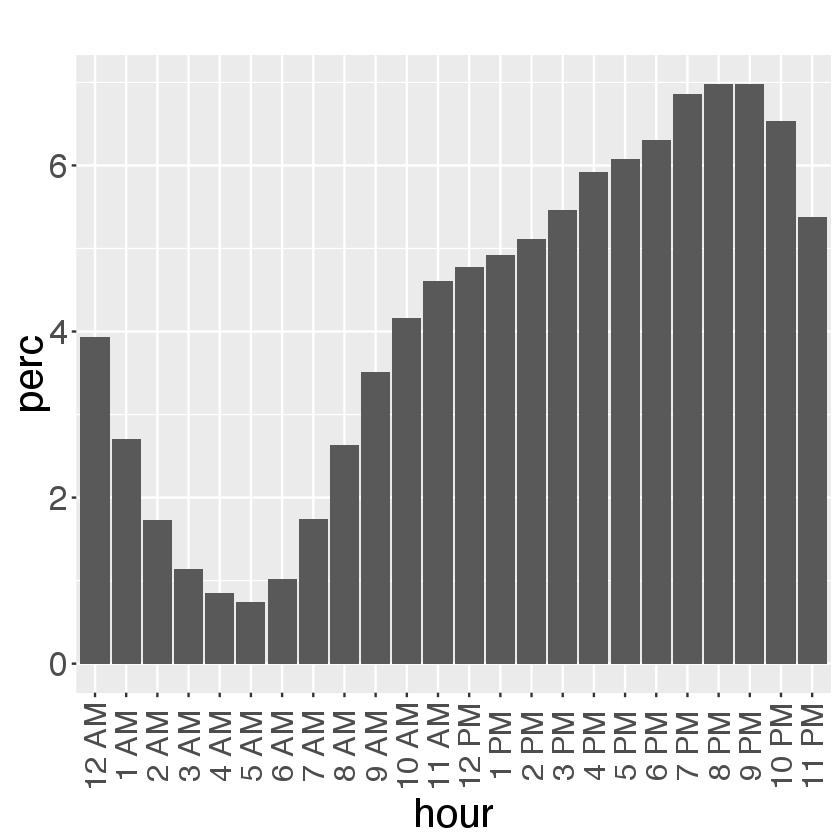

In [3]:
searches$hour <- searches$QueryTime %>% format(., "%H") %>% as.numeric()
hour_count <- plyr::count(searches, vars = "hour") %>% .[order(.$hour), ]
hour_count$hour <- ifelse(hour_count$hour >= 12, paste(hour_count$hour%%12, "PM"), paste(hour_count$hour, "AM")) 
hour_count$hour <- ifelse(hour_count$hour == "0 AM", "12 AM", hour_count$hour)
hour_count$hour <- ifelse(hour_count$hour == "0 PM", "12 PM", hour_count$hour) %>% factor(., levels = ., ordered = T)
hour_count$perc <- round(hour_count$freq*100/sum(hour_count$freq), 2)

generic.ggplot(hour_count, x.axis = "hour", y.axis = "perc", plot.type = "bar.dodge", 
               save.figure = F, print.figure = F, x.rot = 90, x.lbl.size = 18)

Here we see the same plot in a polar coordinate format, which may be more intuitve to visualise and understand.

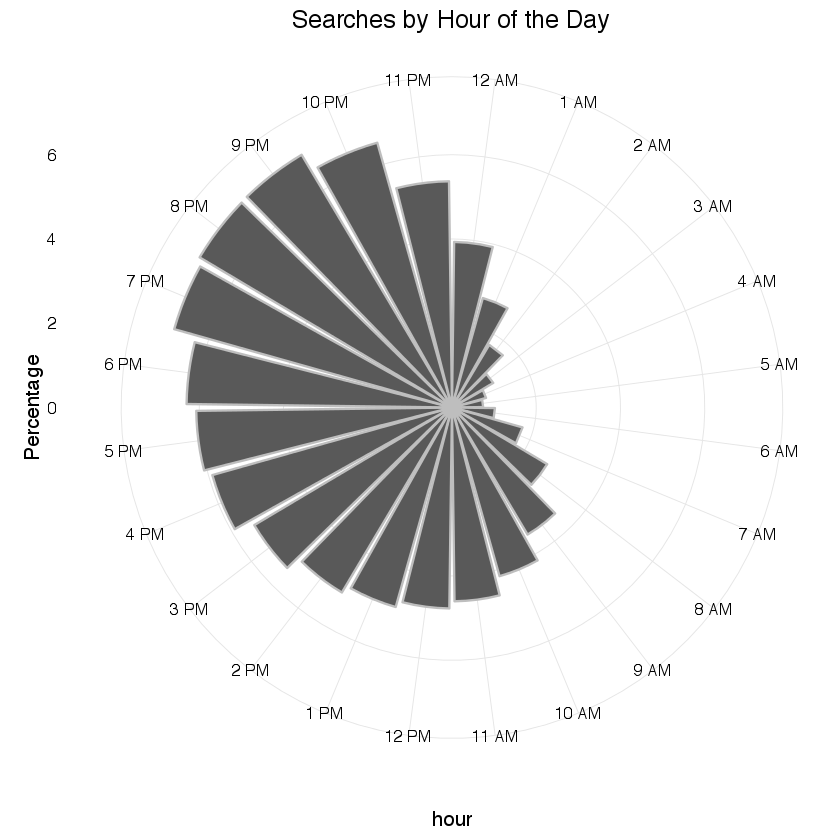

In [4]:
ggplot(hour_count) + geom_bar(aes(x = hour, y = perc), stat = "identity", colour = "grey") + coord_polar(start = 0) + theme_minimal() + scale_fill_brewer() + 
  ylab("Percentage") + ggtitle("Searches by Hour of the Day")

## Search Volume by Day of the Month
Here, we're looking at how search volumes change over the course of the month. Query volumes are fairly consistent across the month, except for a dip on the 17th and 31st. The dip on the 31st can be explained by the fact that April only has 30 days, and therefore the data for searches on the 31st day of the month come only from March and May.

**Suggestion for Product Managers** - first, we need to see if this pattern is consistent across a longer time period (over the course of a year, for example). If so, further investigation is necessary to see why there is such a steep drop only on this day

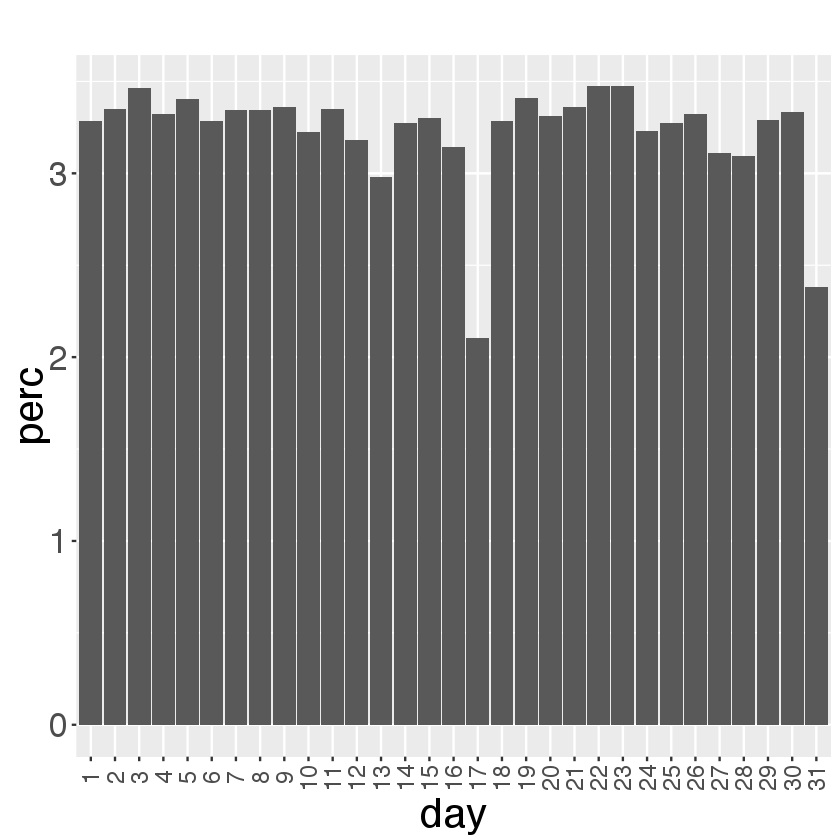

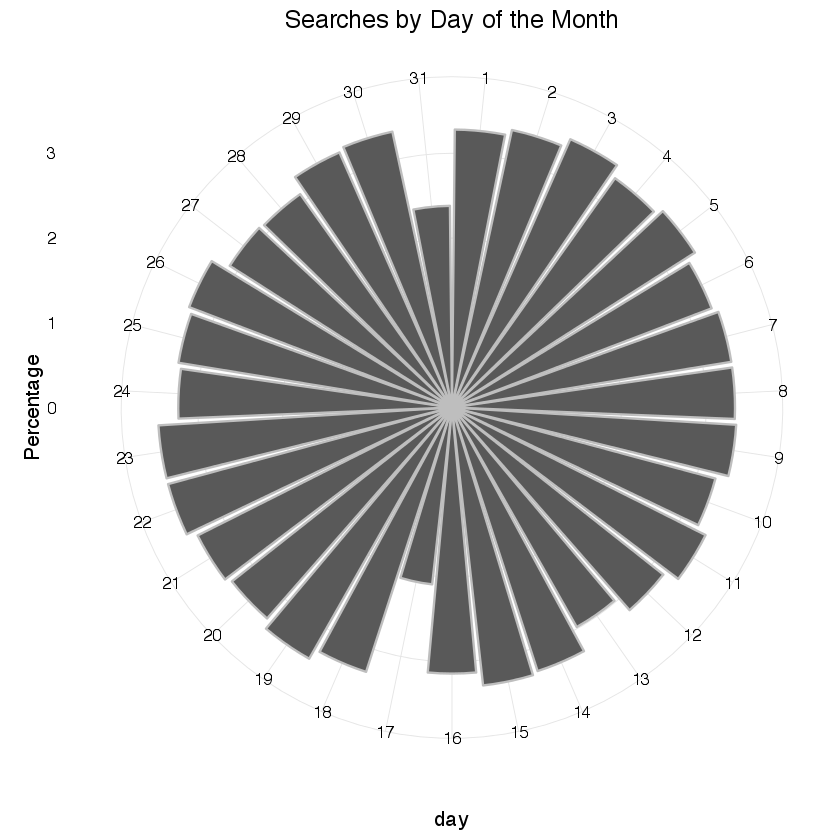

In [5]:
searches$day <- searches$QueryTime %>% format(., "%d") %>% as.numeric()
searches$weekday <- weekdays(searches$QueryTime)

day_count <- plyr::count(searches, vars = "day") %>% .[order(.$day), ]
day_count$day <- day_count$day %>% factor(., levels = ., ordered = T)
day_count$perc <- round(day_count$freq*100/sum(day_count$freq), 2)

generic.ggplot(day_count, x.axis = "day", y.axis = "perc", plot.type = "bar.dodge", save.figure = F, print.figure = F, x.lbl.size = 14, x.rot = 90)
ggplot(day_count) + geom_bar(aes(x = day, y = perc), stat = "identity", colour = "grey") + coord_polar(start = 0) + theme_minimal() + scale_fill_brewer() + 
  ylab("Percentage") + ggtitle("Searches by Day of the Month") 

## Top Queries

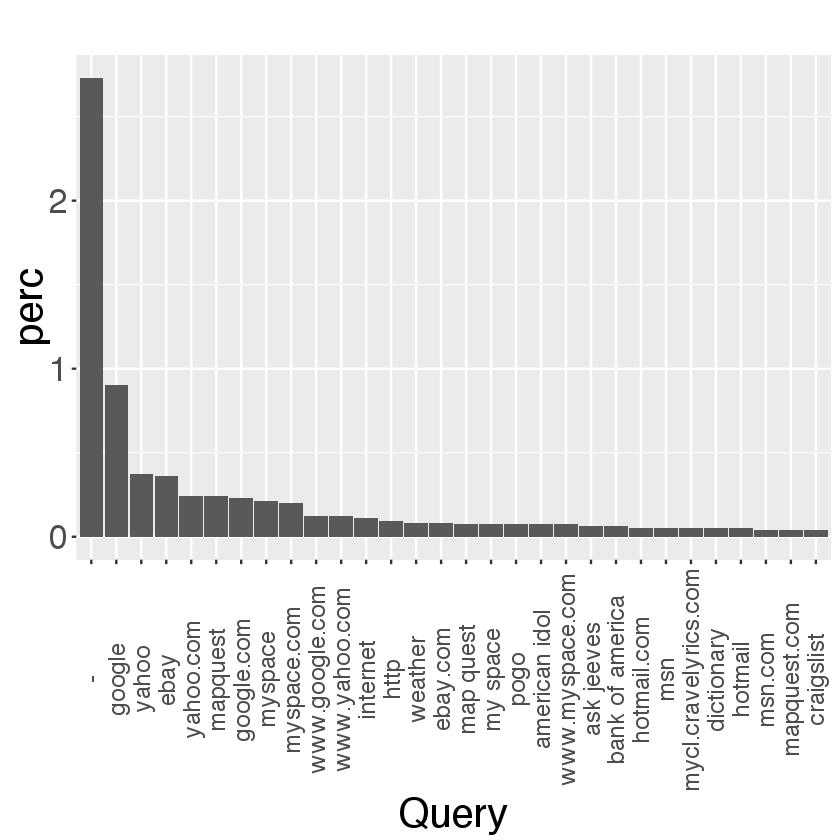

In [6]:
query_count <- plyr::count(searches, vars = "Query") %>% .[order(-.$freq), ]
query_count$Query <- query_count$Query %>% factor(., levels = ., ordered = T)
query_count$perc <- round(query_count$freq*100/sum(query_count$freq), 2)
query_count <- query_count %>% .[.$perc > quantile(.$perc, 0.5), ]
generic.ggplot(query_count[1:30, ], x.axis = "Query", y.axis = "perc", plot.type = "bar.dodge", save.figure = F, print.figure = F, x.lbl.size = 14, x.rot = 90, y.comma = T)

## Distribution of clicks based on page

Here we look at where clicks take place - how often do clicks take place on page 1 vs page 2 and beyond? I use log frequency because the first page commands most of the more than 10x as many clicks as the 2nd page.

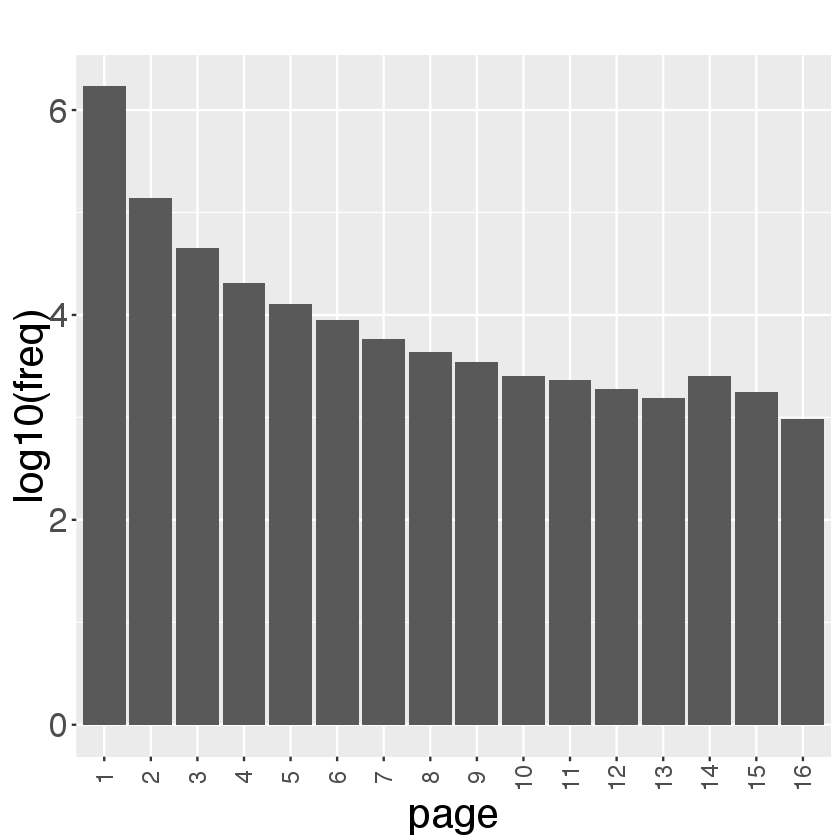

In [7]:
searches$page <- floor(searches$ItemRank/10+1)
page_count <- plyr::count(searches, vars = "page") %>% .[order(.$page), ] %>% .[!is.na(.$page), ]
page_count$page <- page_count$page %>% factor(., levels = ., ordered = T)
page_count$perc <- round(page_count$freq*100/sum(page_count$freq), 2)
page_count2 <- page_count %>% .[.$perc >= 0.05, ]

generic.ggplot(page_count2, x.axis = "page", y.axis = "log10(freq)", plot.type = "bar.dodge", 
               save.figure = F, print.figure = F, x.lbl.size = 14, x.rot = 90, y.comma = T)

As you can see, the first page accounts for approximately 85-86% of total clicks

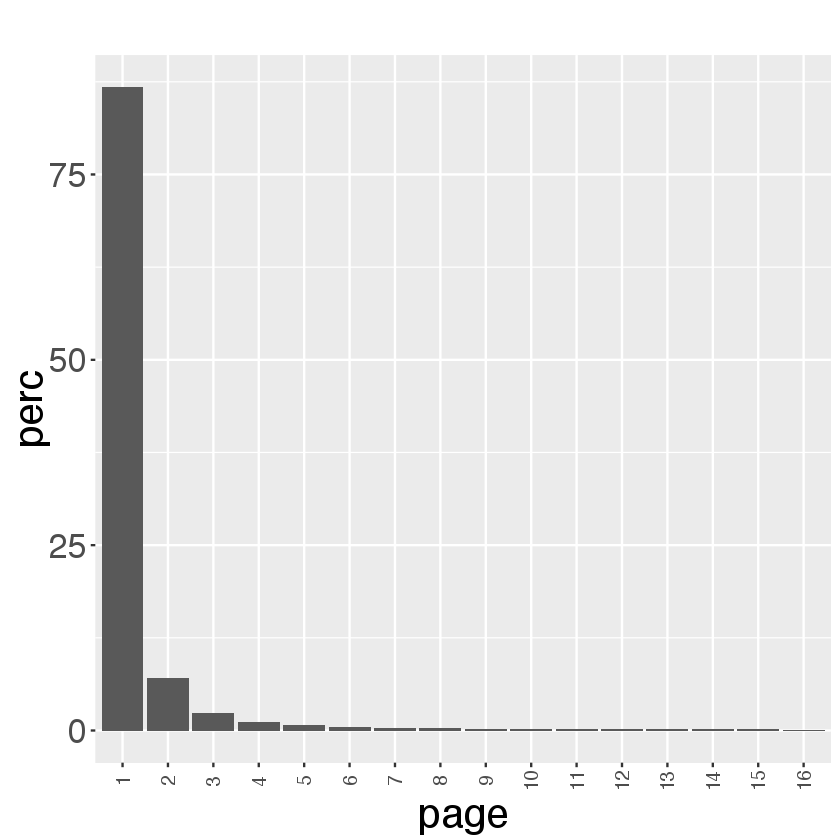

In [8]:
generic.ggplot(page_count2, x.axis = "page", y.axis = "perc", plot.type = "bar.dodge", save.figure = F, 
               print.figure = F, x.lbl.size = 11, x.rot = 90, y.comma = T) #+ 

## Top URLs

Top URLs clicked on by users

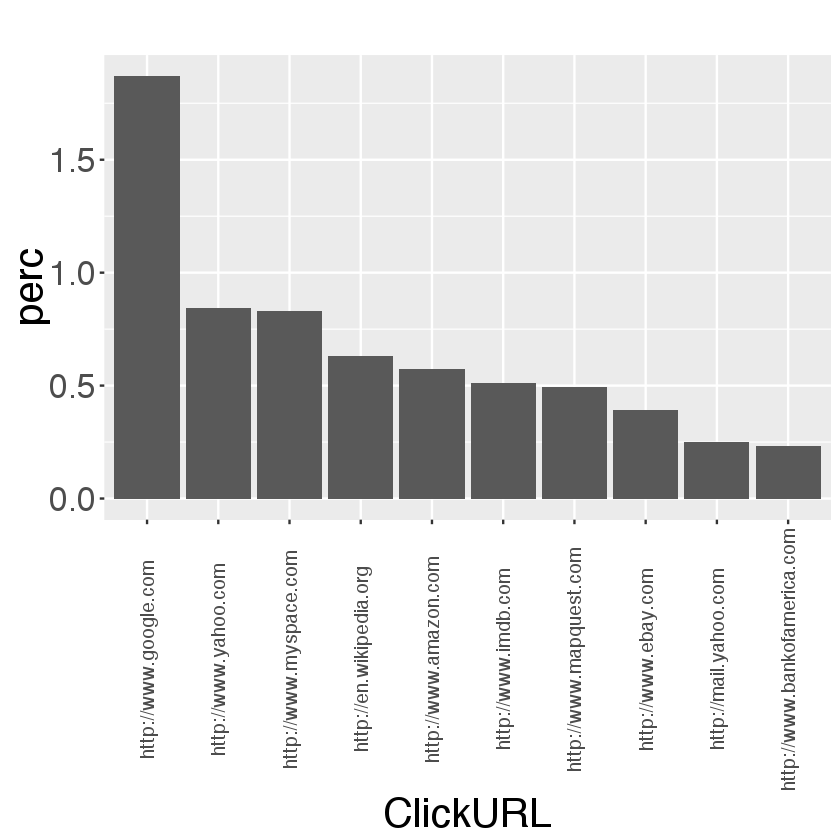

In [9]:
url_count <- plyr::count(searches, vars = "ClickURL") %>% .[order(-.$freq), ]
url_count <- url_count %>% .[!is.na(.$ClickURL), ] %>% .[.$ClickURL != "", ]
url_count$perc <- round(url_count$freq*100/sum(url_count$freq), 2)
url_count.top10 <- url_count[1:10, ]
url_count.top10$ClickURL <- url_count.top10$ClickURL %>% factor(., levels = ., ordered = T)
generic.ggplot(url_count.top10, x.axis = "ClickURL", y.axis = "perc", plot.type = "bar.dodge", 
               save.figure = F, print.figure = F, x.lbl.size = 11, x.rot = 90, y.comma = T)

## Query Length

Distribution of number of words per query

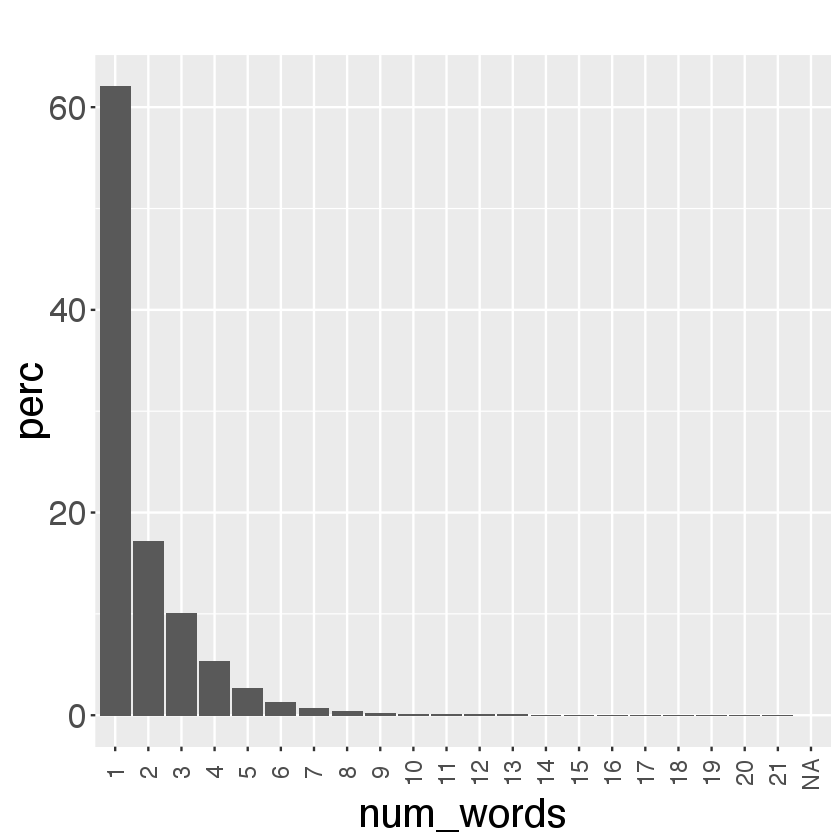

In [13]:
searches$num_words <- searches$Query %>% gregexpr(" |,", .) %>% sapply(., length)
# searches$num_words <- ifelse(searches$num_words == -1, 1, searches$num_words)

num_words_count <- plyr::count(searches, vars = c("num_words"))
num_words_count <- num_words_count %>% .[.$freq > 100, ]
num_words_count$num_words <- num_words_count$num_words %>% factor(., levels = ., ordered = T)
num_words_count$perc <- num_words_count$freq*100/sum(num_words_count$freq)
generic.ggplot(num_words_count[1:35, ], x.axis = "num_words", y.axis = "perc", plot.type = "bar.dodge", 
               save.figure = F, print.figure = F, x.lbl.size = 14, x.rot = 90, y.comma = T)

## Percentage of clicks by page

Warning message in `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, :
“duplicated levels in factors are deprecated”Warning message in `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, :
“duplicated levels in factors are deprecated”Warning message in `levels<-`(`*tmp*`, value = if (nl == nL) as.character(labels) else paste0(labels, :
“duplicated levels in factors are deprecated”

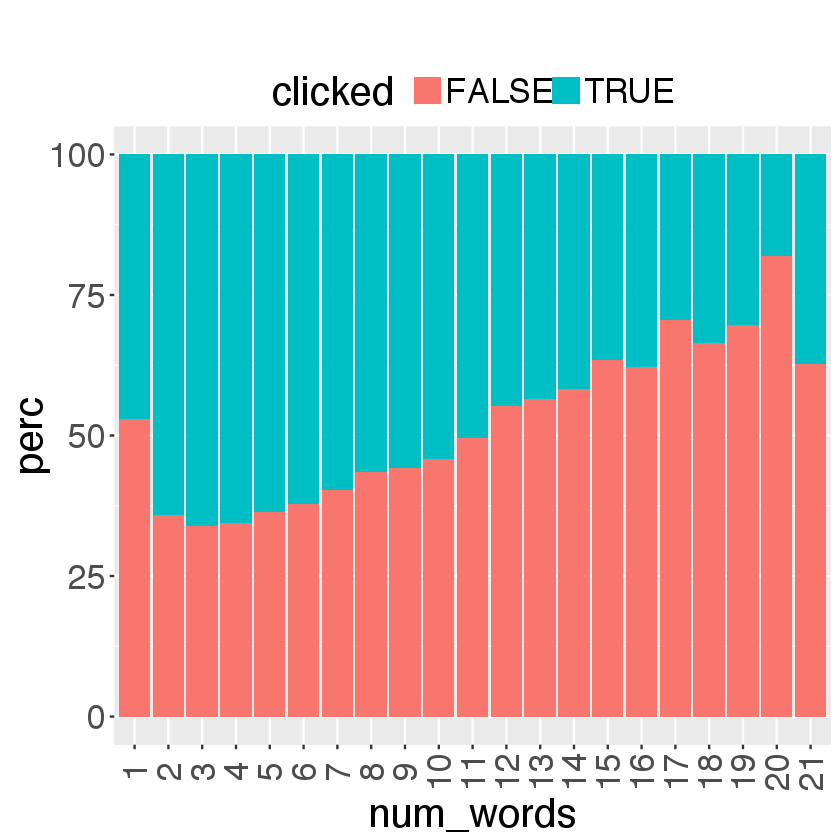

In [14]:
searches$clicked <- ifelse(is.na(searches$ItemRank), F, T)
clicked.num_words <- plyr::count(searches, vars = c("num_words", "clicked"))
colnames(clicked.num_words) <- c("num_words", "clicked", "freq")
clicked.num_words <- clicked.num_words %>% .[order(.$num_words), ]
clicked.num_words$num_words <- clicked.num_words$num_words %>% as.numeric()
clicked.num_words$perc <- sapply(1:nrow(clicked.num_words), function(r) {
  same.num.words <- which(clicked.num_words$num_words == clicked.num_words$num_words[r])
  clicked.num_words$freq[r]*100/sum(clicked.num_words$freq[same.num.words])
})
clicked.num_words <- clicked.num_words %>% .[.$num_words <= num_words_count$num_words %>% as.numeric() %>% max(), ]

clicked.num_words$num_words <- clicked.num_words$num_words %>% factor(., levels = ., ordered = T)
generic.ggplot(clicked.num_words, x.axis = "num_words", y.axis = "perc", fill = "clicked", y.comma = T,
               plot.type = "bar.stack", save.figure = F, print.figure = F, x.rot = 90, x.lbl.size = 20)

## Queries that resulted in clicks

In [15]:
searches$clicked <- ifelse(!is.na(searches$ItemRank), T, F)
query.clicked <- plyr::count(searches, vars = c("Query", "clicked")) %>% .[.$Query %in% query_count$Query[1:1000], ] %>% .[order(-.$freq), ]
query.clicked$perc <- sapply(1:nrow(query.clicked), function(r) {
  same.query <- which(query.clicked$Query == query.clicked$Query[r])
  clicked.num_words$freq[r]*100/sum(clicked.num_words$freq[same.query], na.rm = T)
})

query.clicked$Query <- query.clicked$Query %>% as.character()
query.clicked.top20 <- query.clicked %>% .[.$Query %in% levels(query_count$Query)[1:20], ] %>% .[order(-.$perc), ]

query.notclicked.top100 <- query.clicked %>% .[.$clicked == F, ] %>% .[order(-.$perc), ] %>% .[1:100, ]
query.clicked.top100 <- query.clicked %>% .[.$clicked == T, ] %>% .[order(-.$perc), ] %>% .[1:100, ]

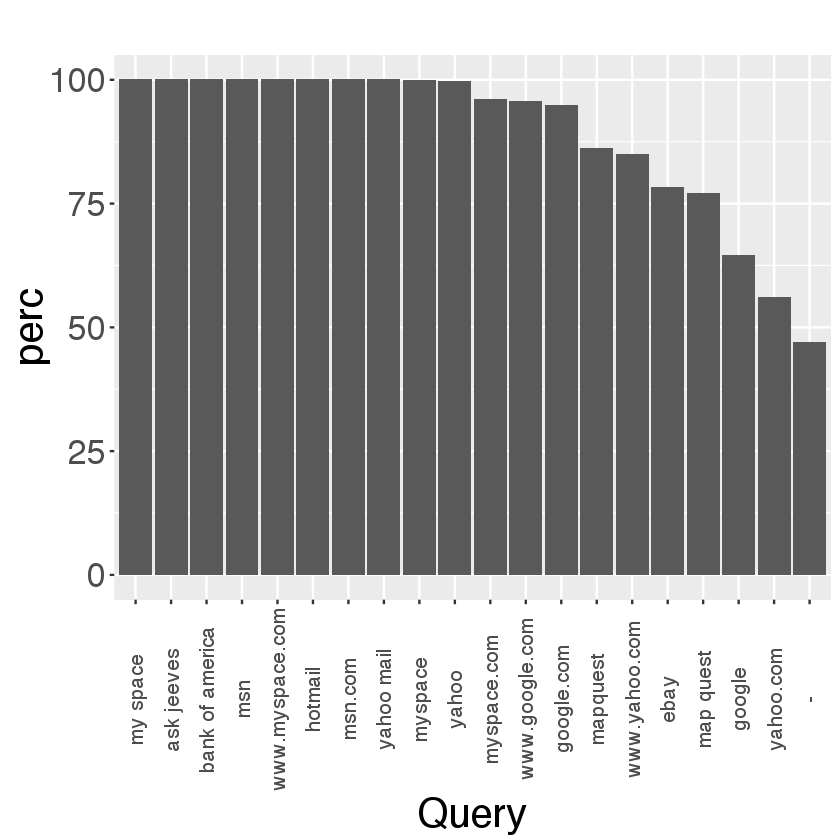

In [16]:
query.clicked.top100$Query <- query.clicked.top100$Query %>% factor(., levels = ., ordered = T)
generic.ggplot(query.clicked.top100[1:20, ], x.axis = "Query", y.axis = "perc",y.comma = T,
               plot.type = "bar.dodge", save.figure = F, print.figure = F, x.rot = 90, x.lbl.size = 12)

## Queries that did not result in clicks

y-axis represents the percentage of times the query did not receive a click

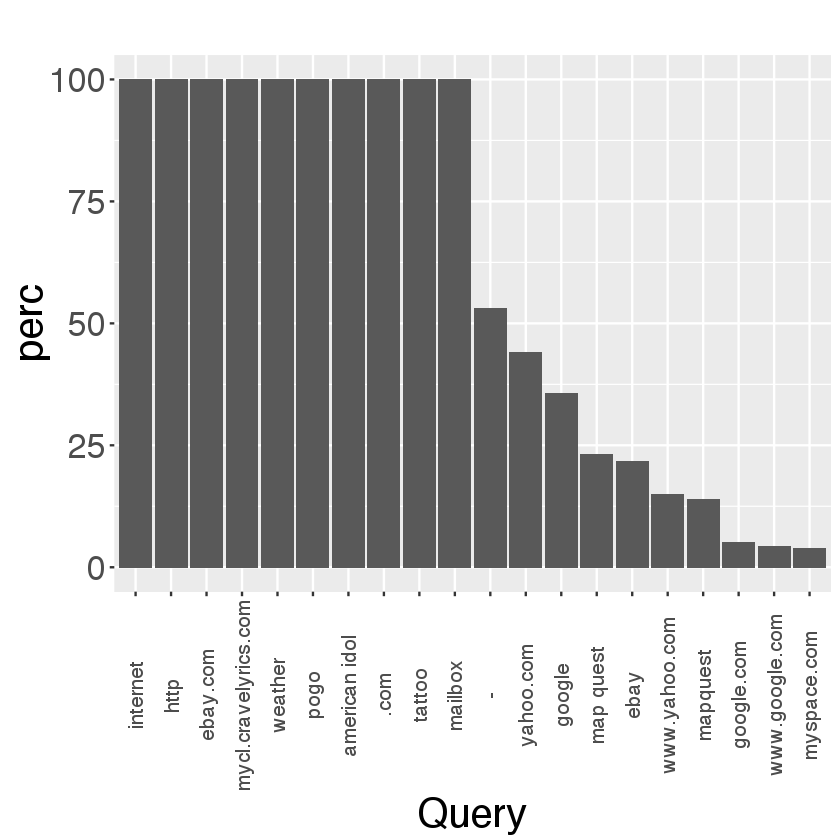

In [17]:
query.notclicked.top100$Query <- query.notclicked.top100$Query %>% factor(., levels = ., ordered = T)
generic.ggplot(query.notclicked.top100[1:20, ], x.axis = "Query", y.axis = "perc", y.comma = T,
               plot.type = "bar.dodge", save.figure = F, print.figure = F, x.rot = 90, x.lbl.size = 12)

# Clustering

### Clustering Queries

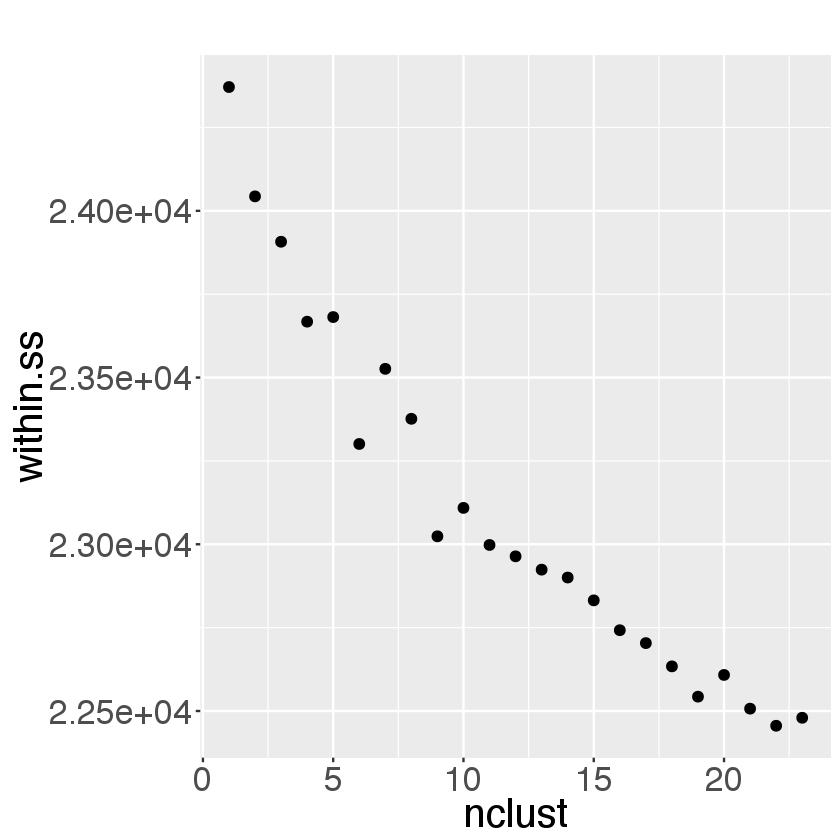

In [23]:
# dtm.sample.10k <- create_matrix(searches$Query %>% .[sample(length(.), 1e4)], stemWords=TRUE, removeStopwords=FALSE, minWordLength=1, removePunctuation= TRUE)
dtm.sample.10k <- readRDS('data/dtm.sample.10k.RDS')

# cost_df <- data.frame()
# for(i in 1:25) {
#   kmeans.dtm <- kmeans(x=dtm.sample.10k, centers=i, iter.max=100)

#   #Combine cluster number and cost together, write to df
#   cost_df<- rbind(cost_df, cbind("nclust" = i, "within.ss" = kmeans.dtm$tot.withinss))  
# }
cost_df <- readRDS('data/cost_df.RDS')
generic.ggplot(cost_df, x.axis = "nclust", y.axis = "within.ss", plot.type = "scatter", save.figure = F, print.figure = F, y.scientific = T)

 1. Algorithm - I used a k-means algorithm. The reason I chose this is that with a large dataset such as the search one, it was the simplest and would likely have been the fastest to run. Alternatives that I've used in the past are DBSCAN and OPTICS. These are more complex, and find non-spherical clusters, and would have taken far too long. I would use them as a 2nd step.
 2. Number of clusters - The best way, in my opinion, to choose the number of clusters is to do it empirically. Clustering is an unsupervised learning technique so there's no "correct" answer. I tried a number of clusters and used a plot of how the 'within cluster sum of squares' changed as a function of the number of clusters. As the number of clusters increases, the 'within_ss' drops until a point where it stops dropping as sharply. At that point, it would be reasonable to say that there's not much more advantage to be gained by adding more clusters.
 3. Distance metric - Euclidean distance

In [19]:
url.patterns <-  "^http|^www|\\.com$|\\.[a-z][a-z]+ |\\.[a-z][a-z]+$|\\.[a-z][a-z][a-z]|^google$|^yahoo$"
searches$contains.url <- ifelse(grepl(pattern = url.patterns, x = searches$Query, ignore.case = T), TRUE, FALSE)

searches$travel.event.intent <- ifelse(grepl(pattern = "ticket|travel | flight | train | bus ", x = searches$Query, ignore.case = T), TRUE, FALSE)

Warning message in grepl(pattern = url.patterns, x = searches$Query, ignore.case = T):
“input string 33183 is invalid in this locale”Warning message in grepl(pattern = url.patterns, x = searches$Query, ignore.case = T):
“input string 33184 is invalid in this locale”Warning message in grepl(pattern = url.patterns, x = searches$Query, ignore.case = T):
“input string 33187 is invalid in this locale”Warning message in grepl(pattern = url.patterns, x = searches$Query, ignore.case = T):
“input string 33192 is invalid in this locale”Warning message in grepl(pattern = url.patterns, x = searches$Query, ignore.case = T):
“input string 341408 is invalid in this locale”Warning message in grepl(pattern = "ticket|travel | flight | train | bus ", x = searches$Query, :
“input string 33183 is invalid in this locale”Warning message in grepl(pattern = "ticket|travel | flight | train | bus ", x = searches$Query, :
“input string 33184 is invalid in this locale”Warning message in grepl(pattern = "ticket|tra

In [24]:
searches$QueryTime <-as.POSIXct(searches$QueryTime)
searches.users <- ddply(.data = searches, .variables = "AnonID", .fun = summarise,
                        num_queries = length(AnonID),
                        avg_query_length = mean(num_words, na.rm = T),
                        contains_url_perc = sum(contains.url)/length(contains.url),
                        travel_event_intent = sum(travel.event.intent)/length(travel.event.intent),
                        weekend_perc = length(which(weekday %in% c("Saturday", "Sunday")))/length(weekday),
                        perc_workday = length(which(hour >= 8 & hour <= 20 & !weekday %in% c("Saturday", "Sunday")))/length(weekday),
                        perc_latenight = length(which(hour >= 22))/length(hour),
                        perc_earlymorn = length(which(hour >=4 & hour <= 7))/length(hour),
                        clicked_perc = sum(!is.na(ItemRank))/length(ItemRank))

In [38]:
# algos <- c("rf", "svmRadialWeights", "svmLinearWeights", "knn", "lda")
searches.users.sample <- searches.users %>% .[sample(1:nrow(.), 0.2*nrow(.)), ]

searches.users$clicked_perc2 <- ifelse(searches.users$clicked_perc > 0.5, "likely_to_click", "not_likely")
searches.users2 <- searches.users %>% .[, !colnames(.) %in% "clicked_perc"]

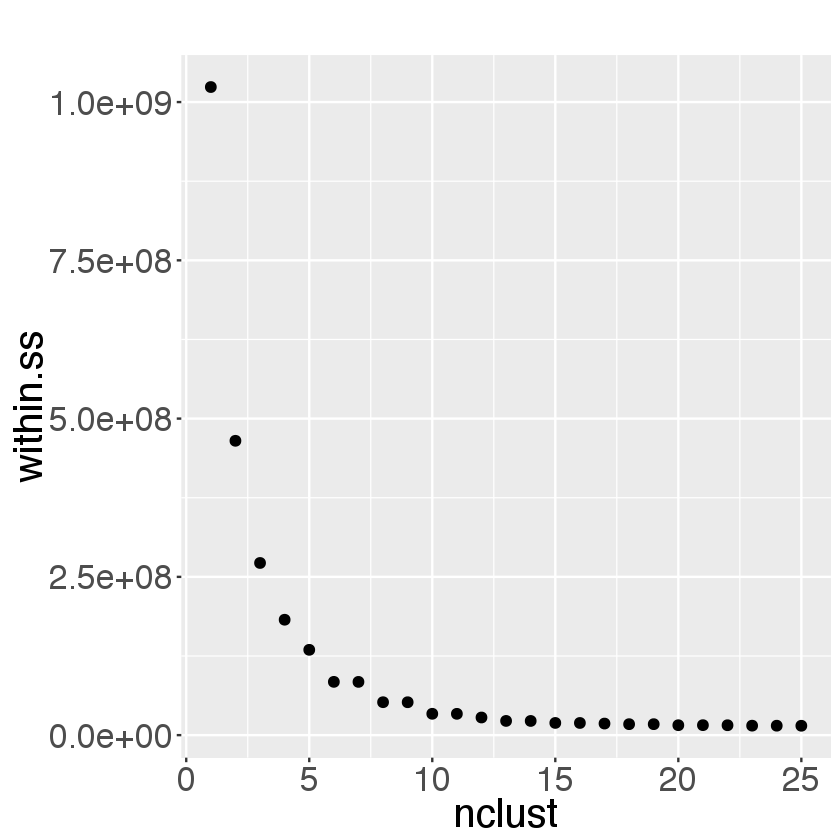

In [43]:
cost_df_users <- data.frame()
for(i in 1:25) {
  kmeans.users <- kmeans(x = searches.users %>% .[, seq(2, ncol(.)-1)], centers = i, iter.max = 100)

  #Combine cluster number and cost together, write to df`
  cost_df_users <- rbind(cost_df_users, cbind("nclust" = i, "within.ss" = kmeans.users$tot.withinss))  
}
generic.ggplot(cost_df_users, x.axis = "nclust", y.axis = "within.ss", plot.type = "scatter", title = "User Clusters",
               save.figure = F, print.figure = F, y.scientific = T)

In [ ]:
algos <- c("rf")
train.control <- trainControl(method = "cv", number = 3, classProbs = TRUE, summaryFunction = twoClassSummary, savePredictions = T)

results <- matrix(nrow = 0, ncol = 2, dimnames = list(c(), list("model", "ROC"))) %>% as.data.frame()

# for(algo in algos) {
#     print(algo)
  model <- train(clicked_perc2 ~ ., data = searches.users.sample, trControl = train.control, method = algos, metric = "ROC", tuneLength = 5)
  start.col <- which(colnames(model$results) == "ROC")
  results <- rbind(results, cbind("model" = rep(algo, nrow(model$results)), "ROC" = model$results[, "ROC"]))
  
  results$ROC <- as.numeric(results$ROC)
  
  assign(algo, model$results)
# }
generic.ggplot(results, x.axis = "ROC", plot.type = "density", clr = "model", print.figure = T, save.figure = F, lgnd = T)